In [1]:
import os,sys,shutil
import numpy as np
import time
import matplotlib.pyplot as plt
from mpm_rect import mpm_rect
sys.path.append(os.getcwd()+'/build')
import MPM_2D
from tqdm import tqdm, trange
import math

In [2]:
#Defining the Spring
Emod = 1e5; Density = 1500; Poisson = 0.3
xp = 500; yp = xp;                       #Number of particles along X and Y direction
l=0.06; b=l                              #Length of grid
MPV = mpm_rect([l,2*l], [l,b], [xp,yp],1 )
Truss = MPM_2D.MPM_NHSolid(Emod, Density, Poisson, MPV)
Truss.MPC()[:,18] = -1400
NoMP = Truss.NoMP

p=int(yp*(np.ceil(xp/2)))

In [3]:
#Defining the grid
x_0 = 0; y_0 = 0;                               #Origin of X and Y Axis
lx = l*3; ly = lx;                              #Length of grid in X and Y direction
nx = 7; ny = nx;                                #Number of cells in X and Y direction

Grid = MPM_2D.MPM_Grid(L=[lx, ly], N=[nx, ny], O=[x_0, y_0])
NoNodes = Grid.NoNodes

In [4]:
dx = lx/nx; dy = ly/ny
# fig, ax = plt.subplots(1, 1, figsize = (5, 5))                                  #creating axis
# ax.set_xlim(x_0,x_0+lx); ax.set_ylim(y_0,y_0+ly)                                #set limits
# ax.scatter(Truss.MPC()[:,0], Truss.MPC()[:,1] ,s=Truss.MPC()[:,4]*1e5,c='black')
# for i in range (nx+1):
#     ax.plot([x_0+dx*i,x_0+dx*i],[y_0,ly+y_0], c=(0.9, 0.9, 0.9, 1.0) )          #Plot X lines
#     for j in range (ny+1):
#         ax.plot([x_0,lx+x_0],[y_0+dy*j,y_0+dy*j], c=(0.9, 0.9, 0.9, 1.0) )      #Plot Y lines

In [6]:
#Prepare postprocessing
plotstarget_directory = os.path.join(os.getcwd(), "Truss_plots")

#Create a new directory to store the plots (delete when there)
if os.path.exists(plotstarget_directory) and os.path.isdir(plotstarget_directory):
    shutil.rmtree(plotstarget_directory)
os.mkdir(plotstarget_directory)
print("Plots will be saved to : ", plotstarget_directory)

def save_plot(current_time):
    dx = lx/nx; dy = ly/ny
    fig, ax = plt.subplots(1, 1, figsize = (5, 5))                                  #creating axis
    ax.set_xlim(x_0,x_0+lx); ax.set_ylim(y_0,y_0+ly)                                #set limits
    ax.scatter(Truss.MPC()[:,0], Truss.MPC()[:,1] ,s=Truss.MPC()[:,4]*1e5,c='black')
    for i in range (nx+1):
        ax.plot([x_0+dx*i,x_0+dx*i],[y_0,ly+y_0], c=(0.9, 0.9, 0.9, 1.0) )          #Plot X lines
        for j in range (ny+1):
            ax.plot([x_0,lx+x_0],[y_0+dy*j,y_0+dy*j], c=(0.9, 0.9, 0.9, 1.0) )      #Plot Y lines
    ax.set_aspect(aspect='equal')
    filename = 'Truss_'+str(current_time)+'.png'
    fig.savefig(os.path.join(plotstarget_directory, filename), dpi=400, bbox_inches="tight")
    plt.close()                                                                     #prevent plotting in jupyter notebook
    return

Plots will be saved to :  /home/karthik/cpp/mpm_2d_cpp/Truss_plots


In [7]:
#Prepare postprocessing vtk files
target_directory = os.path.join(os.getcwd(), "Truss_vtk")

# #Create a new directory to store the plots (delete when there)
if os.path.exists(target_directory) and os.path.isdir(target_directory):
    shutil.rmtree(target_directory)
os.mkdir(target_directory)

In [8]:
TrussSolver = MPM_2D.MPM_Solver()                                           #Defining solver
TrussSolver.addBC(lambda X: True if (X[1] >= 0.18) else False, vy=0.0)      #Boundary conditions
alpha = 25                                                                  #Damping factor

#Running through time steps
dt = 1e-5
T  = 2.0
NoS = int(T/dt)
noMicroSteps = int(500)                    #Incremental time step for solver
noMacroSteps = int(NoS/noMicroSteps)       #Number of vtk files

recordx = np.zeros(noMacroSteps)
recordt = np.zeros(noMacroSteps)
dy = np.zeros(noMacroSteps)
dx = np.zeros(noMacroSteps)
dy_0 = Truss.MPC()[p][1]
Time = 0

start_time = time.time()
Grid.VTKGrid(target_directory + "/Grid", 0)
Truss.VTKMaterialpoints(target_directory +"/Truss", 0)
for step in trange (noMacroSteps):
    TrussSolver.Solve(Grid, [Truss], noMicroSteps, dt, alpha)
    #save_plot(step)
    Truss.VTKMaterialpoints(target_directory +"/Truss", step+1)
    #dy[step] = dy_0 - Truss.MPC()[p][1]
    dy[step] = Truss.MPC()[yp-1-p][1] - Truss.MPC()[p][1]
    dx[step] = Truss.MPC()[(xp*yp-1),0] - Truss.MPC()[(yp-1),0]
    Time = Time + dt*noMicroSteps
    recordx[step] = Truss.MPC()[p][1]
    recordt[step] = Time;
print("--- %s seconds ---" % (time.time() - start_time))

100%|██████████| 399/399 [7:11:29<00:00, 64.89s/it]--- 25901.18648982048 seconds ---



Final =  0.11990250809935027
Damped =  0.12004685831817942


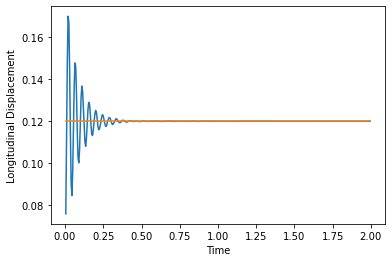

In [9]:
#plot Longitudinal displacement
dy_mpm = np.ones(noMacroSteps) * (np.sum(dy)/noMacroSteps)
plt.xlabel('Time')
plt.ylabel('Longitudinal Displacement')    
#plt.plot(recordt,recordx)
plt.plot(recordt,dy)
plt.plot(recordt,dy_mpm)
#plt.plot(recordt,dy_act)
#print(dy_0 - Truss.MPC()[p][1])                   #Displaced value
print("Final = ", Truss.MPC()[yp-1-p][1] - Truss.MPC()[p][1]) #Total length of deformed truss
print("Damped = ", np.sum(dy)/noMacroSteps)

Final =  0.032266212467504815
Damped =  0.03230006886795407


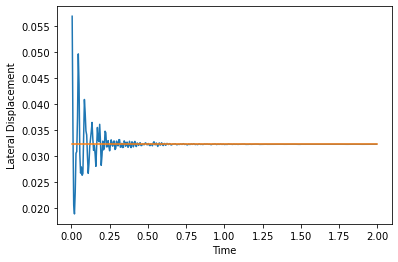

In [10]:
#plot Lateral displacement
dx_mpm = np.ones(noMacroSteps) * np.sum(dx)/noMacroSteps
plt.xlabel('Time')
plt.ylabel('Lateral Displacement')    
plt.plot(recordt,dx)
plt.plot(recordt,dx_mpm)
print("Final = ", Truss.MPC()[(xp*yp-1),0] - Truss.MPC()[(yp-1),0])     #Total breadth of deformed truss
print("Damped = ", np.sum(dx)/noMacroSteps)

In [11]:
# x=np.array([20,25,50,100,150,200,250,400,600,1000])
# y=np.array([0.1026,0.1085,0.0704,0.0629,0.0612,0.0606,0.0605,0.0602,0.0600,0.0600])
# fig, ax = plt.subplots(1, 1, figsize = (5, 5))
# #ax.set_xlim(0,500);                                #set limits
# ax.set_xlabel('Number of Material points')
# ax.set_ylabel('Longitudinal displacement')    
# ax.plot(x,y )          #Plot X lines
# fig.savefig("Truss_dy(7x7)", dpi=400, bbox_inches="tight")

In [12]:
# x=np.array([3,5,7,9,13,15,19,23,27,33])
# y=np.array([0.0248,0.0284,0.0293,0.0296,0.0304,0.0306,0.0310,0.0313,0.0314,0.0317])
# fig, ax = plt.subplots(1, 1, figsize = (5, 5))
# #ax.set_xlim(,13);                                #set limits
# ax.set_xlabel('Number of Material points')
# ax.set_ylabel('Lateral displacement')    
# ax.plot(x,y )          #Plot X lines
# fig.savefig("Truss_dx(5x5)", dpi=400, bbox_inches="tight")